<a href="https://colab.research.google.com/github/comchem/Pytorch_DeepLearning_Tutorials/blob/master/Sec6-RNN_%26_TimeSeries/5-Nonlinear_Sequence_SimpleRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

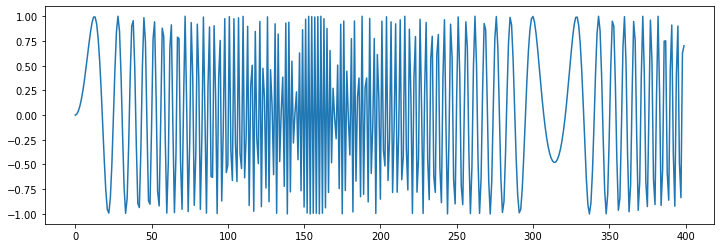

In [2]:
# make the original data
series = np.sin((0.1*np.arange(400))**2)
plt.figure(figsize=(12,4))
plt.plot(series)
plt.show()

This is a time series of the form:

$$x(t) = sine(wt^2)$$

In [4]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []

for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1,T, 1)   # Reshape N x T x D : 3 dimensions
Y = np.array(Y).reshape(-1,1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (390, 10, 1) Y.shape (390, 1)


In [5]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
### Define RNN
class RNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(RNN, self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        
        self.rnn = nn.GRU(
          input_size = self.D,
          hidden_size = self.M,
          num_layers = self.L,
          batch_first = True)
    
        self.fc = nn.Linear(self.M, self.K)
    
    def forward(self, X):
        # initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        
        # get RNN unit output
        # out is of size (N, T, M)
        # 2nd return value is hidden states at each hidden layer
        # we don't need those now
        out, _ = self.rnn(X, h0)
        
        # we only want h(T) at the final time step
        # N x M --> N x K
        out = self.fc(out[:, -1, :])
        return out

In [9]:
# Instantiate the model
model = RNN(n_inputs = 1, n_hidden=5, n_rnnlayers = 1, n_outputs = 1)
model.to(device)

RNN(
  (rnn): GRU(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [10]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)

In [11]:
# Make inputs and targets
X_train = torch.from_numpy(X[:N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:N//2].astype(np.float32))
X_test = torch.from_numpy(X[N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[N//2:].astype(np.float32))

In [12]:
# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [13]:
# Training
def full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs = 200):
    # Stuff to store
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for it in range(epochs):
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        # Save losses
        train_losses[it] = loss.item()
        
        # Test loss
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[it] = test_loss.item()
        
        if (it+1) % 5 == 0:
            print(f'Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss:  {test_loss.item():.4f}')
    
    return train_losses, test_losses

In [14]:
train_losses, test_losses = full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test)

Epoch 5/200, Train Loss: 0.5107, Test Loss:  0.5478
Epoch 10/200, Train Loss: 0.5022, Test Loss:  0.6352
Epoch 15/200, Train Loss: 0.4744, Test Loss:  0.5243
Epoch 20/200, Train Loss: 0.3918, Test Loss:  0.5034
Epoch 25/200, Train Loss: 0.3023, Test Loss:  0.3046
Epoch 30/200, Train Loss: 0.2151, Test Loss:  0.2081
Epoch 35/200, Train Loss: 0.1689, Test Loss:  0.2060
Epoch 40/200, Train Loss: 0.1316, Test Loss:  0.1666
Epoch 45/200, Train Loss: 0.0848, Test Loss:  0.1531
Epoch 50/200, Train Loss: 0.0669, Test Loss:  0.1066
Epoch 55/200, Train Loss: 0.0479, Test Loss:  0.0968
Epoch 60/200, Train Loss: 0.0328, Test Loss:  0.0717
Epoch 65/200, Train Loss: 0.0257, Test Loss:  0.0677
Epoch 70/200, Train Loss: 0.0300, Test Loss:  0.0710
Epoch 75/200, Train Loss: 0.0208, Test Loss:  0.0521
Epoch 80/200, Train Loss: 0.0168, Test Loss:  0.0446
Epoch 85/200, Train Loss: 0.0141, Test Loss:  0.0415
Epoch 90/200, Train Loss: 0.0111, Test Loss:  0.0395
Epoch 95/200, Train Loss: 0.0094, Test Loss:  0

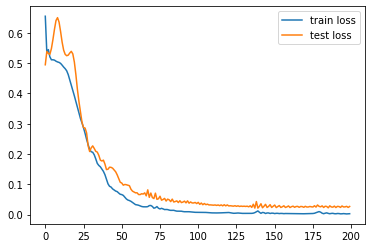

In [15]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label = 'train loss')
plt.plot(test_losses, label = 'test loss')
plt.legend()
plt.show()

In [16]:
# One-step forecast using true targets
# Note: even the one-step forecast fails badly

validation_target = Y[N//2:]
validation_predictions = []

# index of first validation input
i = 0

while len(validation_predictions) < len(validation_target):
    input_ = X_test[i].reshape(1,T,1)
    p = model(input_)[0,0].item()     # 각 row에 따라 나누어 prediction 하기 때문에 [0,0] item으로 값을 받음 -> scalar
    i += 1
    
    # update the predictions list
    validation_predictions.append(p)

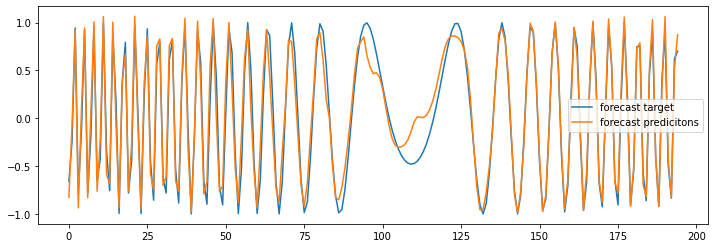

In [18]:
plt.figure(figsize=(12,4))
plt.plot(validation_target, label = 'forecast target')
plt.plot(validation_predictions, label = 'forecast predicitons')
plt.legend()
plt.show()

In [19]:
# Multi-step forecast future values (use only self-predictions for making future predictions)

validation_target = Y[N//2:]
validation_predictions = []

# last train input
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
    input_ = last_x.reshape(1,T,1)
    p = model(input_)
    
    # update the predictions list
    validation_predictions.append(p[0,0].item())
    
    # make the new input
    last_x = torch.cat((last_x[1:], p[0]))   # last_x에서 9개만 선택 후 p[0]의 prediction 값 1개를 row로 추가하여 last_x에 다시 저장
    # cat은 row bind 혹은 col bind와 같은 역할을 함 : torch.cat((x,x,x), 0) -> row, torch.cat((x,x,x),1) -> col

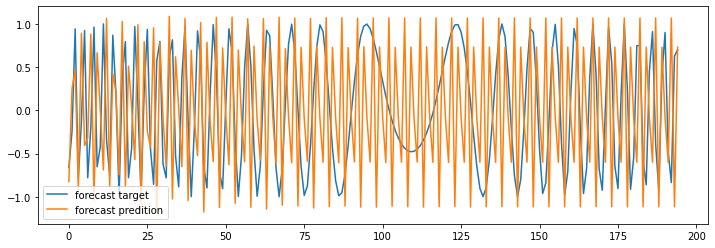

In [21]:
plt.figure(figsize=(12,4))
plt.plot(validation_target, label = 'forecast target')
plt.plot(validation_predictions, label = 'forecast predition')
plt.legend()
plt.show()